# Скоринговая модель прогнозирования вероятности дефолта заемщика банка



## Import

In [1]:
from pandas import Series
import pandas as pd
import pandas_profiling
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

Фиксируем random_seed

In [2]:
random_seed=42

#### Функции

In [3]:
def features_relation(data, columns):
    ''' Наглядный вывод соотношения выбранных признаков к целевой в датасете'''

    sns.set_style('darkgrid')
    
    fig = plt.figure(figsize=(35,10))
       
    for i, value in enumerate(columns):
        plt.subplot(1,len(columns),i+1)
        sns.barplot(x=value, y="default", data=data[[value, 'default']])
        fig.tight_layout(pad=1.0)
        sns.set_context('talk',font_scale=1.1)
    
    fig.subplots_adjust(top=0.8) 

## Data

In [4]:
train = pd.read_csv('train_scoring.csv')
test = pd.read_csv('test_scoring.csv')
sample_submission = pd.read_csv('sample_submission_scoring.csv')

#### Описание признаков

Для корректной обработки признаков объединяем обучающие данные и тестовые в один датасет с соответствующими метками: 

In [5]:
# зададим идикаторы для данных для обучения модели (1) и тестирования (0)
train['sample'] = 1
test['sample'] = 0

# в данных для теста нет значений целевой, так что добавим этот признак с явно отличным значением (-1)
test['default'] = -1 

# объединим данные для целостности обработки признаков по всем подвыборкам
data = pd.concat([train, test], ignore_index=True)

Посмотрим на признаки более детально:

In [6]:
# построим сводный отчет pandas profiling 
data_report = data.profile_report(title='Характеристики признаков', progress_bar=True)

In [7]:
data_report

#### Обработка пропусков

Единственный признак с пропусками данных - образование. Это категориальный признак, пропуски заполним наиболее часто встречающимся значением, исходя из предположения, что большинство обратившихся за кредитом людей имеют образование.   

<AxesSubplot:xlabel='education', ylabel='count'>

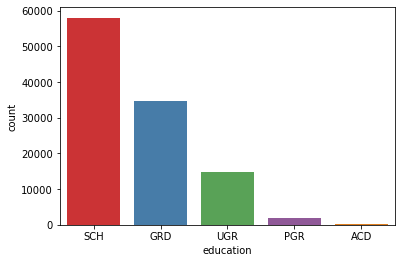

In [8]:
plt.figure() 
sns.countplot(x='education', data = data, palette = 'Set1')

In [9]:
data['education'] = data['education'].fillna('SCH')

### Обработка дат    

Попробуем оценить заявки с точки зрения давности подачи: заменим даты подачи заявки на срок давности от текущей даты в днях.    

In [10]:
data['app_date'] = data['app_date'].apply(lambda x: (pd.Timestamp.today() - pd.to_datetime(x)).days)
data['app_date'] = data['app_date'] - min(data['app_date'])

Разделим признаки по типам:

In [11]:
len(data.columns)

20

In [12]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'sample'],
      dtype='object')

In [13]:
num_cols = ['app_date', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
bin_cols = ['sex', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'car', 'car_type']
help_cols = ['client_id', 'sample']
target_col = ['default']
all_cols = num_cols + bin_cols + cat_cols + help_cols + target_col
len(all_cols)

20

### Бинарные признаки

Посмотрим соотношение бинарных признаков к целевой переменной

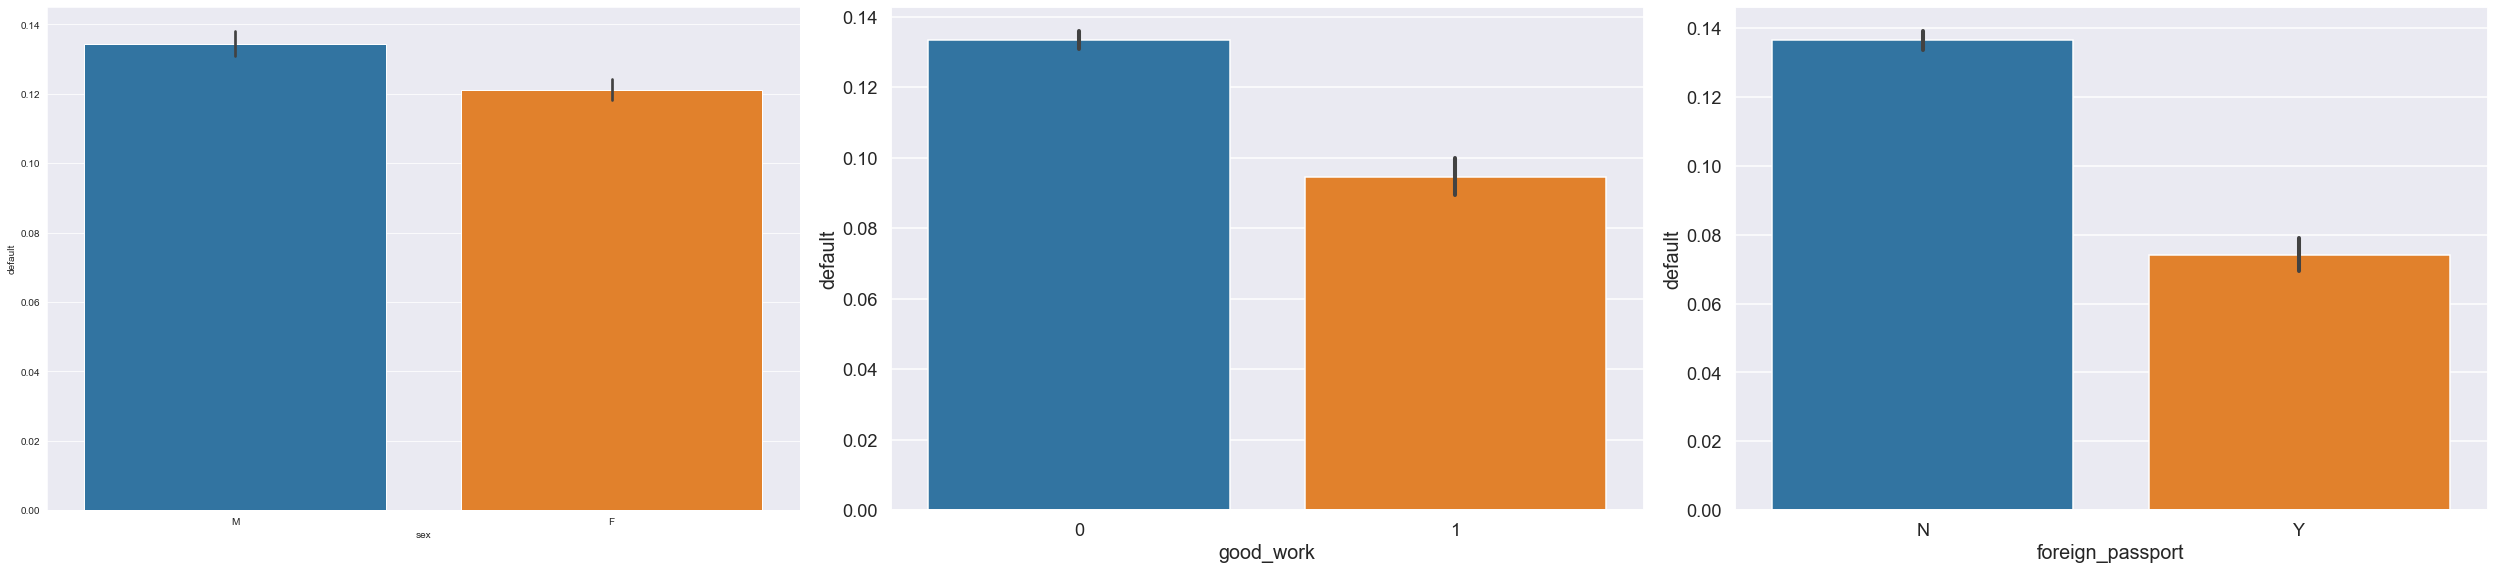

In [14]:
features_relation(train, bin_cols)

Стало видно, что: 

    - мужчины чуть чаще допускают дефолт, чем женщины, 
    - владельцы машин - реже, чем заемщики без машин, 
    - владельцы иномарок - реже, чем владельцы других авто, 
    - заемщики с хорошей работой реже не выплачивают кредит, чем остальные, 
    - владельцы загранпаспорта - реже не имеющих загранпаспорта. 

Владение машиной и владение иномаркой можно объединить,их влияние на дефолт аналогично. 

Адаптируем бинарные признаки для модели:

In [15]:
bin_col_labels = {}
label_encoder = LabelEncoder()
for i in bin_cols:
    data[i] = label_encoder.fit_transform(data[i])
    bin_col_labels[i] = dict(enumerate(label_encoder.classes_))
bin_col_labels

{'sex': {0: 'F', 1: 'M'},
 'good_work': {0: 0, 1: 1},
 'foreign_passport': {0: 'N', 1: 'Y'}}

### Категориальные признаки

In [16]:
cat_col_labels = {}
label_encoder = LabelEncoder()
for i in cat_cols:
    data[i] = label_encoder.fit_transform(data[i])
    cat_col_labels[i] = dict(enumerate(label_encoder.classes_))
cat_col_labels

{'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'},
 'region_rating': {0: 20, 1: 30, 2: 40, 3: 50, 4: 60, 5: 70, 6: 80},
 'home_address': {0: 1, 1: 2, 2: 3},
 'work_address': {0: 1, 1: 2, 2: 3},
 'sna': {0: 1, 1: 2, 2: 3, 3: 4},
 'first_time': {0: 1, 1: 2, 2: 3, 3: 4},
 'car': {0: 'N', 1: 'Y'},
 'car_type': {0: 'N', 1: 'Y'}}

Посмотрим на взимосвязь категориальных признаков и целевой: 

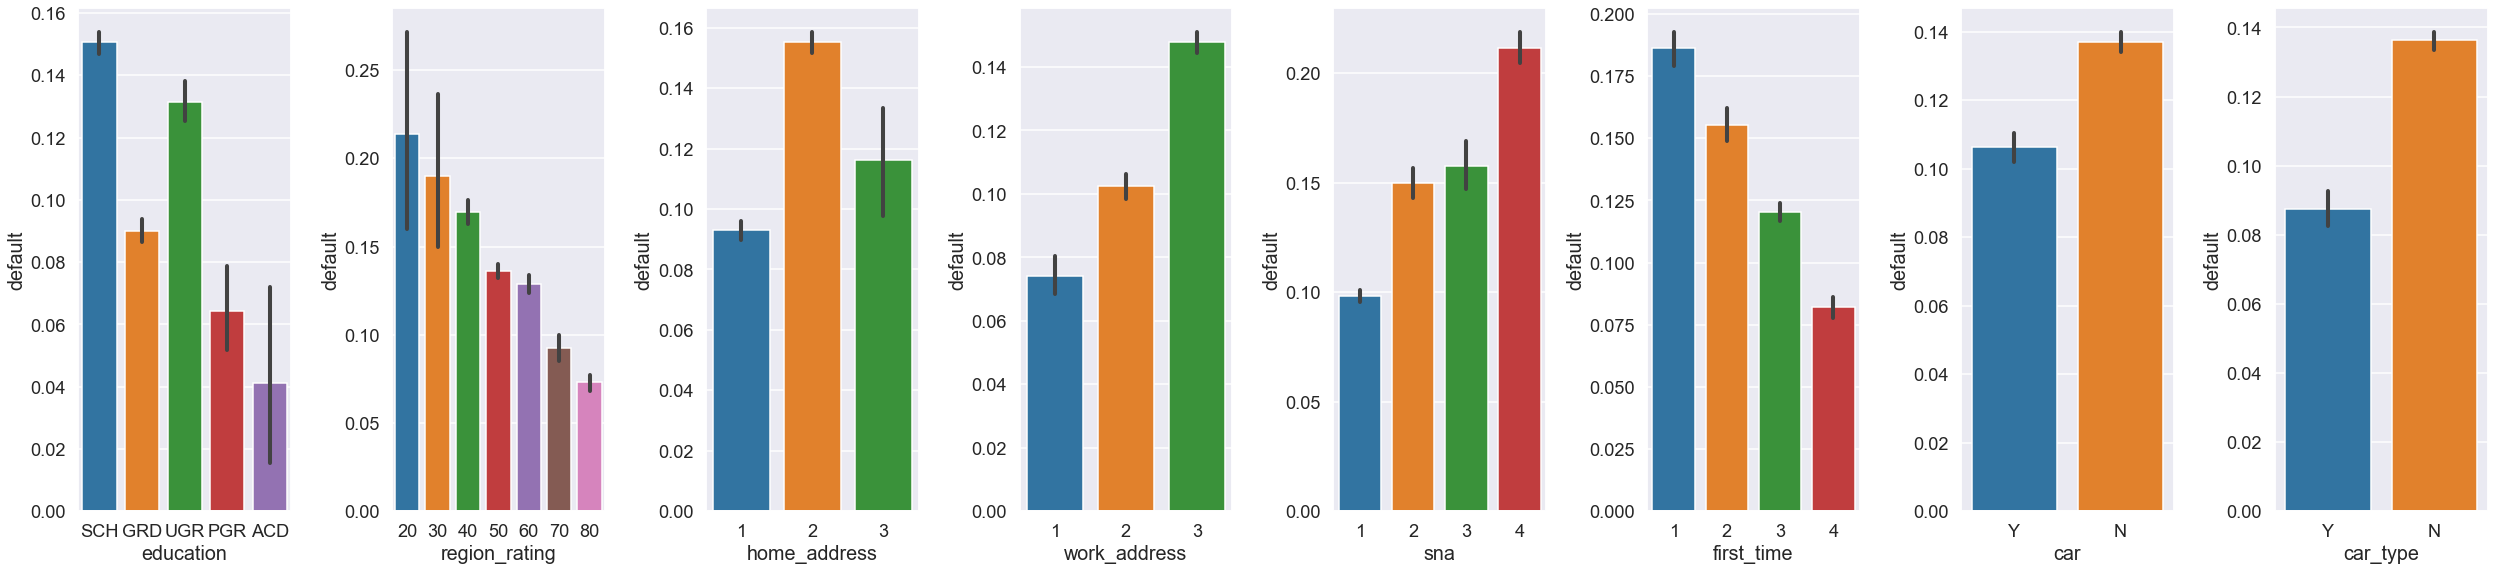

In [17]:
features_relation(train, cat_cols)

Распределения показыают, что: 
    
    - заемщики с уровнем образования ACD допускают дефолт реже остальных категорий,
    - заемщики из регионов проживания с высоким рейтингом наиболее успешны в погашении кредитов,
    - заемщики с домашними адресами первой категории вылачивают кредиты лучше двух других категорий, аналогично с категориями рабочих адресов, 
    - наличие связей с клиентами банка 1 категории характеризует успешных заемщиков, 
    - категория давности информации о заемщике в базе обратнопропорциональна количеству дефолтов в категории.
    


### Значимость категориальных и бинарных признаков для модели 

<AxesSubplot:>

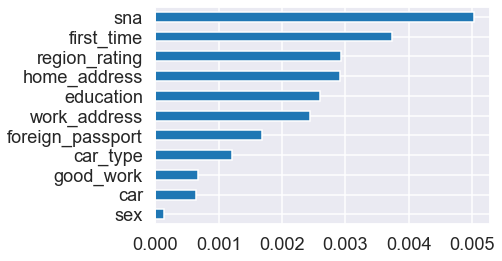

In [18]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols],
                                     data['default'], discrete_features =True),
                                     index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Интересно, что наличие связи заемщика с работниками банка имеет самую большую ценность для модели, и при этом наличие машины не так важно, как какая именно машина есть у заемщика. Значимость пола же вообще очень низка.

### Обработка числовых признаков

Посмотрим на распределение числовых признаков: 

C:\Users\ElenaS\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


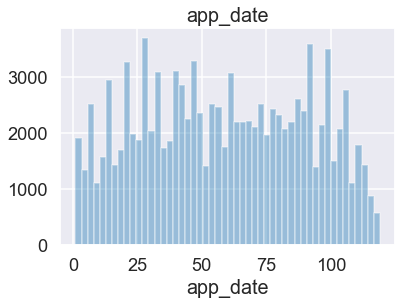

C:\Users\ElenaS\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


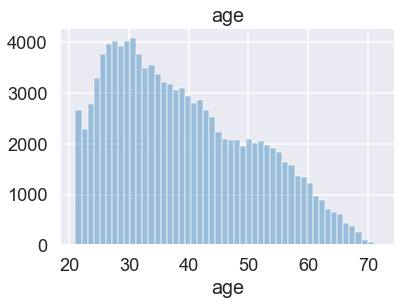

C:\Users\ElenaS\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


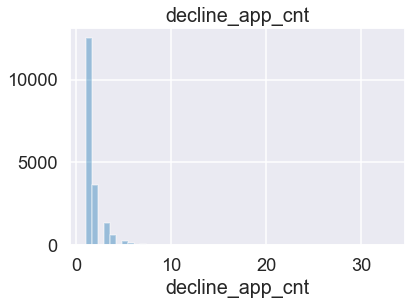

C:\Users\ElenaS\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


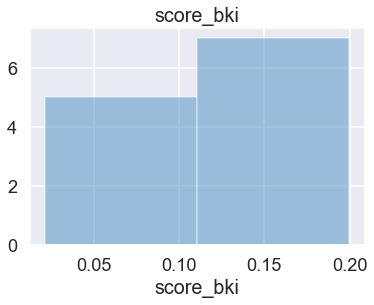

C:\Users\ElenaS\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


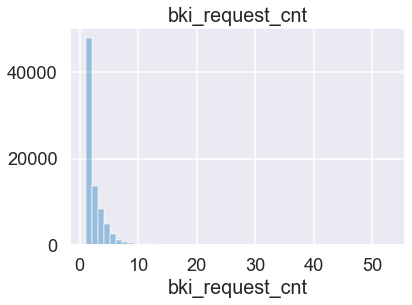

C:\Users\ElenaS\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


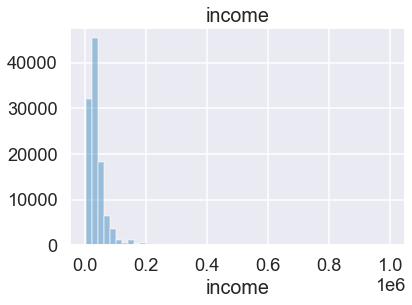

In [19]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Также посмотрим на распределение числовых переменных по отношению к целевой: 

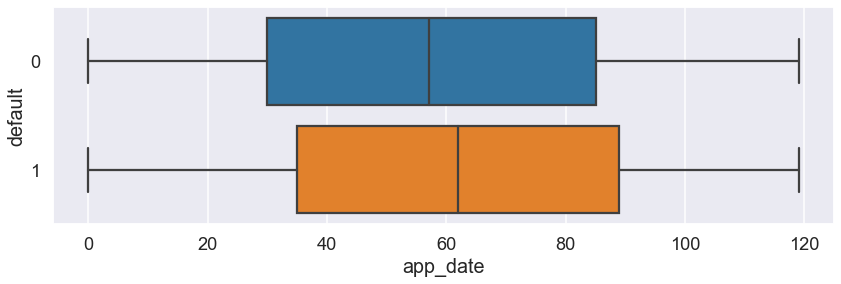

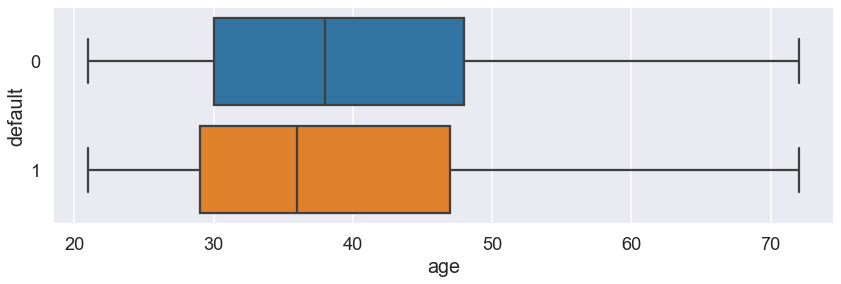

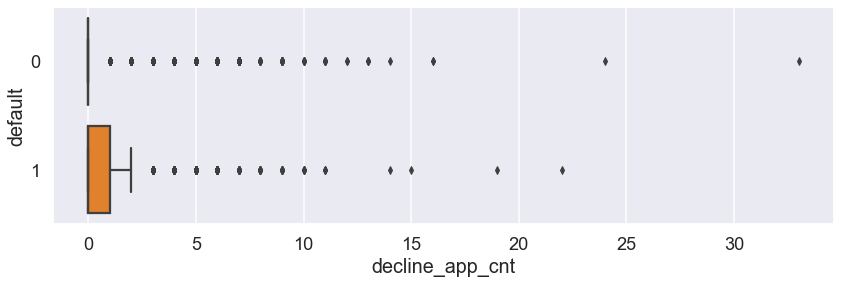

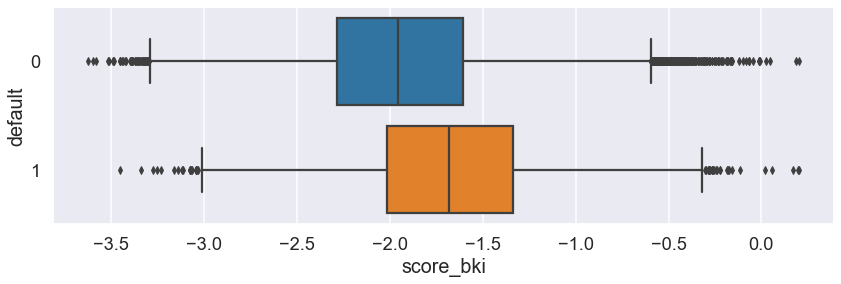

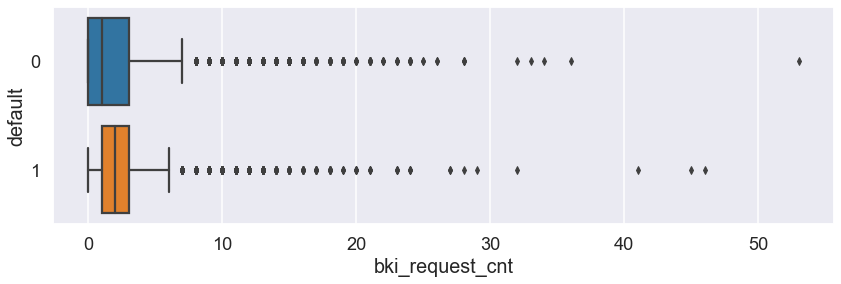

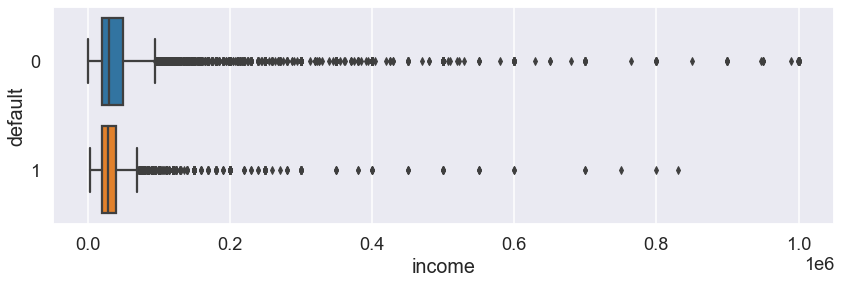

In [20]:
for i in num_cols:
    fig, ax = plt.subplots(figsize = (14, 4)) 
    sns.boxplot(x=data[i], y=data[data['sample']==1]['default'], data=data[data['sample']==1], orient='h')

for i in num_cols:
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=i, 
                data=data[data['default']==1],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot для дефолт-заемщиков, ' + i)
    plt.show()
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=i, 
                data=data[data['default']==0],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot для успешных заемщиков, ' + i)
    plt.show()

Boxplot-ы  показывают, что в среднем, успешные заемщики:
    
    -по возрасту ближе к 40 годам, чем дефолт-заемщики, 
    -количество отказных заявок у них в среднем меньше, но есть и заметно отклоняющиеся показатели, 
    -скоринговый балл БКИ у успешных в среднем меньше, 
    -количество запросов кредитной историии в БКИ у успешных заемщиков меньше, чем у дефолт-заемщиков;
    -показатели дохода у успешных заемщиков смещены в большую сторону.

Числовые признаки показывают смещенное распределение, с длинным правым хвостом, перед обучением модели попробуем нормализовать их для лучшего обучения. 

#### Выбросы

Бокс плоты и описания признаков показали, что аномальных значений, выпадающих за границы здравого смысла нет. Тем не менее, есть сильно отличные показатели в decline_app_cnt  и bki_request_cnt. 

### Оценка корреляции числовых признаков

<AxesSubplot:>

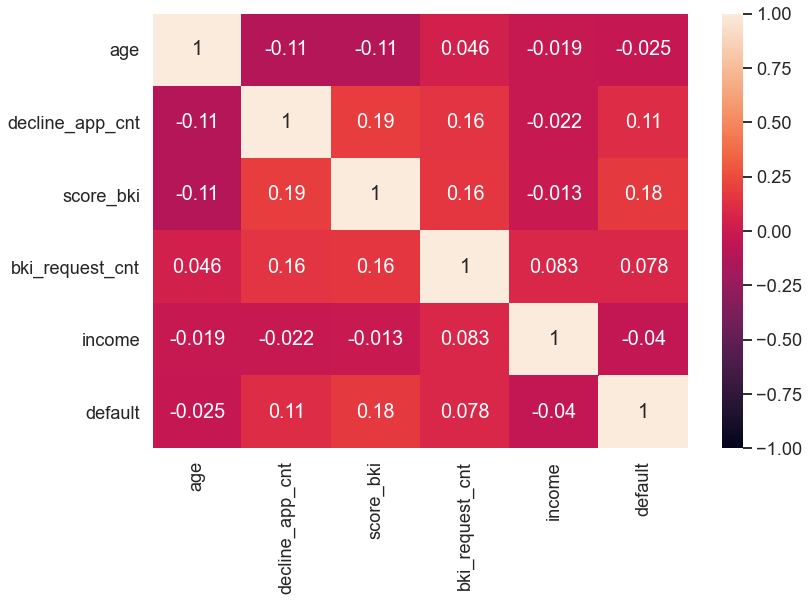

In [21]:
corr = train[num_cols + ['default']].corr()
f, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr, vmax=1, vmin=-1, annot=True)

Все признаки имеют слабую линейную зависимость между собой, так что оставим все.

#### Проверка на сбалансированность классов целевой переменной

<AxesSubplot:xlabel='default', ylabel='count'>

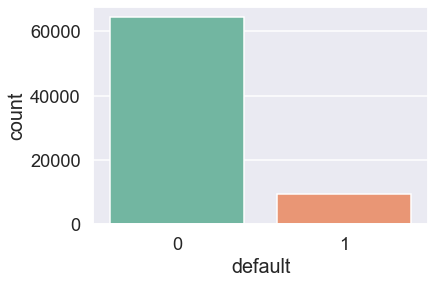

In [22]:
sns.countplot(x ='default', data = train, palette='Set2')

In [23]:
print("Успешных заемщиков:", train.default.value_counts()[0],
             "Дефолт-заемщиков:", train.default.value_counts()[1])

Успешных заемщиков: 64427 Дефолт-заемщиков: 9372


Классы целевой представлены неравномерно, есть дисбаланс. 
Это накладывает ряд следующих ограничений: 
        
    1). Метрики оценки качества модели должны учитывать дисбаланс. Такими являются precision, recall, f1-score, roc-кривые. Accuracy  точно не подойдет.
    2). Для настройки модели полезно будет попробовать настройку гиперпараметров и наращивание представителей класса.

#### Значимость непрерывных переменных 

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA).
В качестве меры значимости будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

<AxesSubplot:>

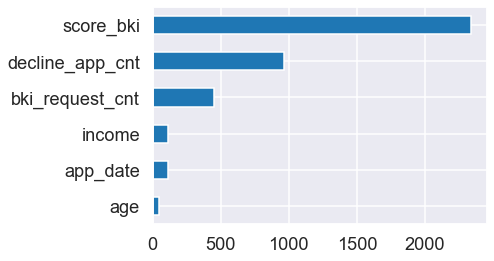

In [24]:
temp_df = data[data['sample'] == 1]
imp_num = Series(f_classif(temp_df[num_cols], temp_df['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Наибольшим f-score обладает скоринговый балл БКИ - $score\_bki$ , и количество отказных кредитных заявок - $decline\_app\_cnt$; эти признаки демонстрируют высокую значимость.

<AxesSubplot:>

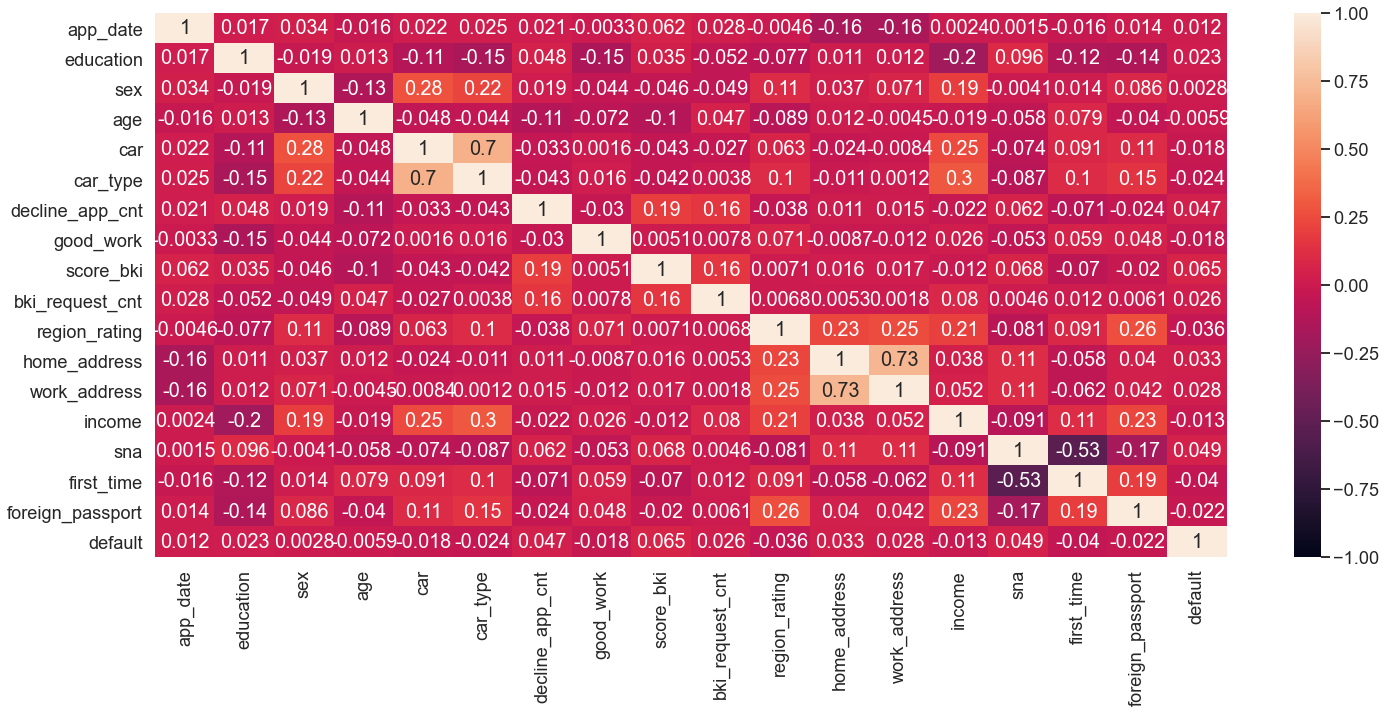

In [25]:
corr_data = data.drop(['sample', 'client_id'], axis=1).corr()
f, ax = plt.subplots(figsize=(24,10))
sns.heatmap(corr_data, vmax=1, vmin=-1, annot=True)

У нас есть признаки, сильно линейно связанные - car  и car_type, и home_adress  и work_adress.
Преобразуем их.

In [26]:
# data.drop(['car'], axis=1, inplace=True)


In [27]:
# bin_cols.remove('car')

Попробуем объединить рабочий и домашний адреса методом декомпозиции.

In [28]:
# Выберем из датасета нужные колонки:
df = data[['work_address', 'home_address']].values

# Создадим Scaler instance:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Из двух столбцов сделаем один путем усечения ненужной информации.
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
data['address'] = pca_data

# Уберем ненужные колонки:
data = data.drop(['home_address','work_address'],axis=1)

# Приведем в порядок списки:
cat_cols.remove('home_address')
cat_cols.remove('work_address')
cat_cols.append('address')

In [29]:
cat_cols

['education',
 'region_rating',
 'sna',
 'first_time',
 'car',
 'car_type',
 'address']

In [30]:
# аналогично попробуем поступить с признаками car и car_type,  они в значительной мере пересекаются в иинформации 
# выбираем нужные колонки: 
df_car = data[['car', 'car_type']].values

#создаем Scaler: 
scaler = StandardScaler()
scaled_cars = scaler.fit_transform(df_car)

# из двух столбцов создаем один: 
pca = PCA(n_components=1)
pca.fit(scaled_cars) 
pca_data_car  = pca.transform(scaled_cars)
data['car_owning'] = pca_data_car

# убираем ненужные колонки: 
data.drop(['car', 'car_type'], axis = 1, inplace=True)

# Чистим список категориальных признаков после изменения
cat_cols.remove('car')
cat_cols.remove('car_type')
cat_cols.append('car_owning')

In [31]:
cat_cols

['education', 'region_rating', 'sna', 'first_time', 'address', 'car_owning']

### Разбиение 

In [32]:
# разделяем данные снова на обучающие и валидационные
data_train = data[data['sample'] == 1].drop(['sample'], axis=1)

x = data_train.drop(['default'], axis = 1)
y = data_train['default']

In [33]:
# разбиение обучающих данных на обучающую и тестовые части 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_seed)

# Наивная модель

In [34]:
naive_model = LogisticRegression()
naive_model.fit(x_train, y_train)

LogisticRegression()

In [35]:
y_pred = naive_model.predict(x_test)

In [36]:
probs = naive_model.predict_proba(x_test)
probs

array([[0.86558394, 0.13441606],
       [0.8594858 , 0.1405142 ],
       [0.87137947, 0.12862053],
       ...,
       [0.85679805, 0.14320195],
       [0.85940316, 0.14059684],
       [0.84164106, 0.15835894]])

In [37]:
probs = probs[:,1]

Построим ROC-кривую наглядно для наивной модели

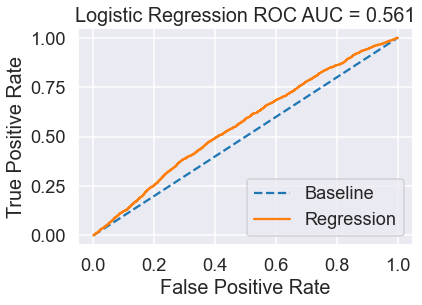

In [38]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Наивная модель предсказывает немногим лучше случайного отгадывания.

Метрики и матрица ошибок наглядно:

<AxesSubplot:>

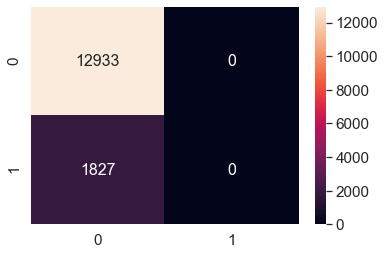

In [39]:
# model_metrics()
# classification_report()
conf_mat = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4) 
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt='g')

Confusion matrix показывает, что модель допускает много ошибок, относя хороших клиентов в категорию неуспешных, и совсем не определяет неуспешных заемщиков. 

## Feature engineering

Сгладим распределение числовых признаков логарифмированием. Экспериментально лучше всего работает логарифмирование дохода. 

In [40]:
num_cols_log = ['income']
for column in num_cols_log:
    data[column] = np.log(data[column] + 5)

Попробуем добавить полиномиальные признаки: 
    

In [41]:
pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(data[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
data = data.join(poly_df, how='left')

<AxesSubplot:>

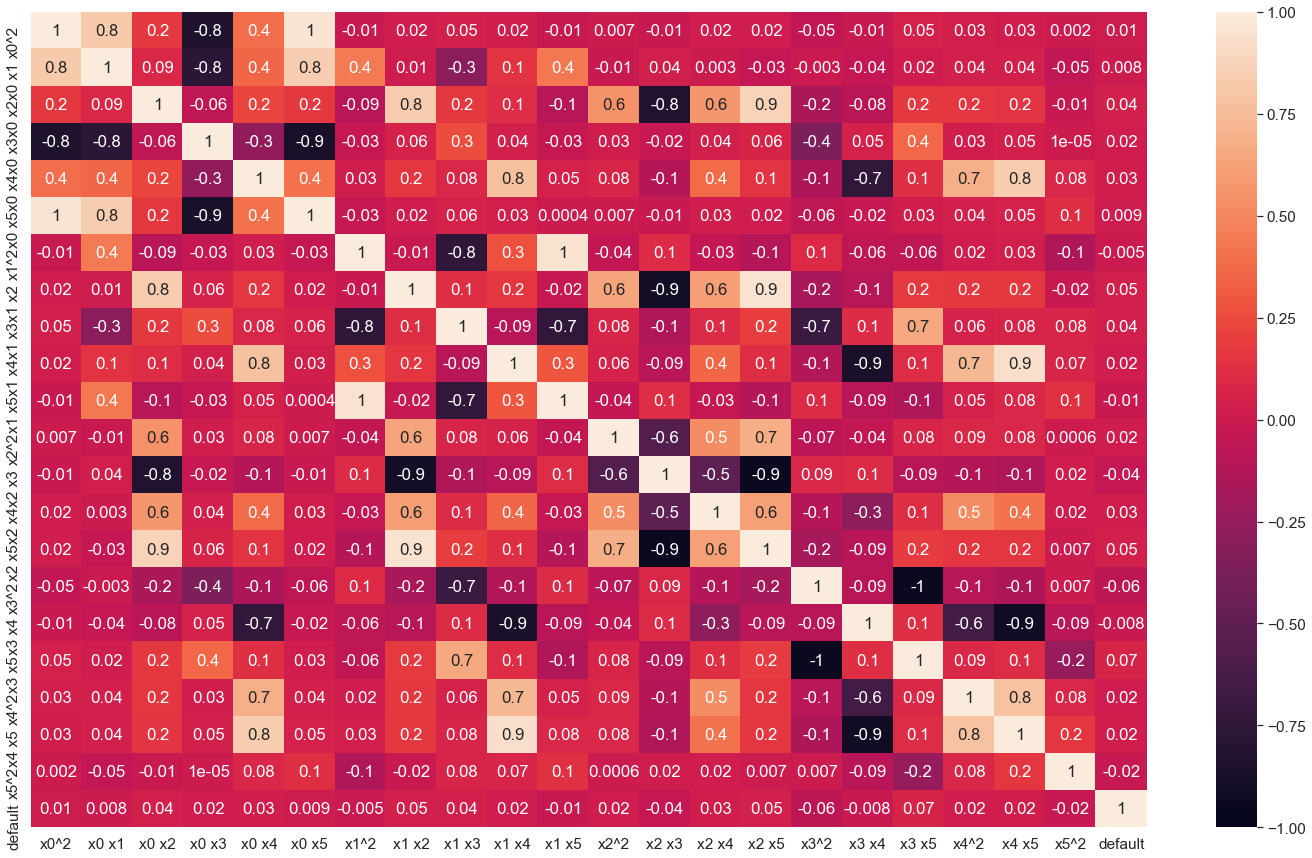

In [42]:
# После добавления новых признаков нужно проверить их корреляцию 

corr = data[poly_cols + ['default']].corr()
f, ax = plt.subplots(figsize=(25,15))
sns.heatmap(corr, vmax=1, vmin=-1, annot=True, fmt = '.1g')

In [43]:
# удалим признаки с высоким показателем линейной корреляции
data.drop(['x0 x1', 'x0 x3', 'x0 x5', 'x1 x2', 'x2 x3', 'x2 x5', 'x3^2', 'x3 x4', 'x3 x5', 'x4^2'], axis=1, inplace=True)

<AxesSubplot:>

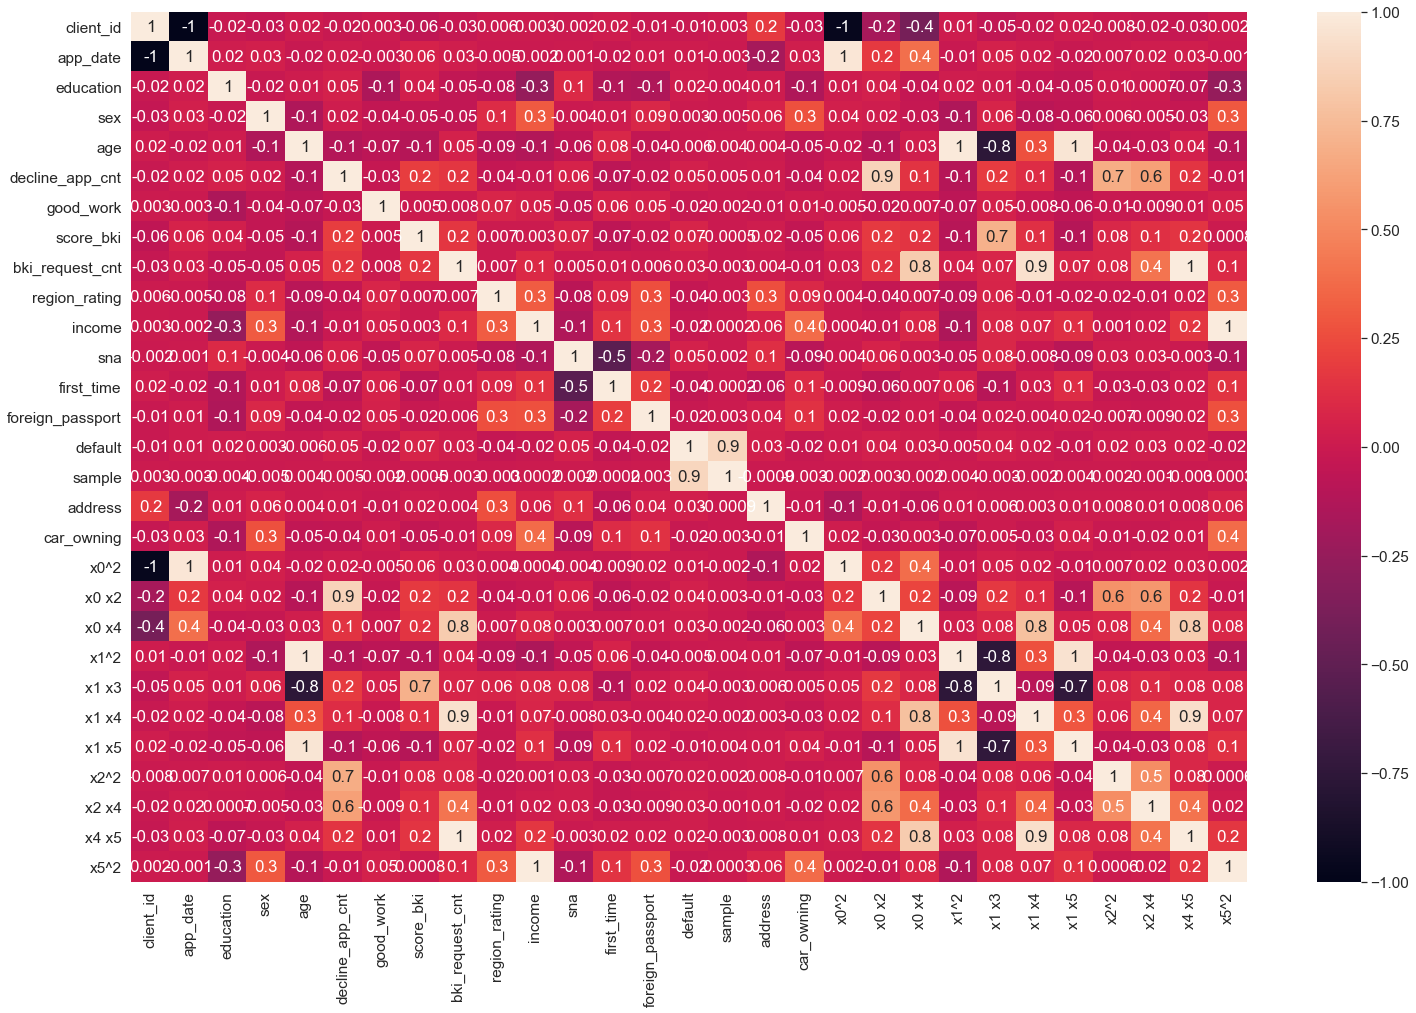

In [44]:
# проверим оставшиеся признаки на линейную корреляцию 
corr = data.corr()

f, ax = plt.subplots(figsize=(25,16))
sns.heatmap(corr, vmax=1, vmin=-1, annot=True, fmt = '.1g')

In [45]:
data.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'decline_app_cnt',
       'good_work', 'score_bki', 'bki_request_cnt', 'region_rating', 'income',
       'sna', 'first_time', 'foreign_passport', 'default', 'sample', 'address',
       'car_owning', 'x0^2', 'x0 x2', 'x0 x4', 'x1^2', 'x1 x3', 'x1 x4',
       'x1 x5', 'x2^2', 'x2 x4', 'x4 x5', 'x5^2'],
      dtype='object')

In [46]:
data.drop(['x0^2', 'x0 x2', 'x0 x4', 'x1^2', 'x1 x3', 'x1 x4',
       'x1 x5', 'x4 x5', 'x5^2'], axis=1, inplace=True)

In [47]:
# почистим список полиномиальных колонок
poly_cols = ['x2^2','x2 x4']
poly_cols

['x2^2', 'x2 x4']

<AxesSubplot:>

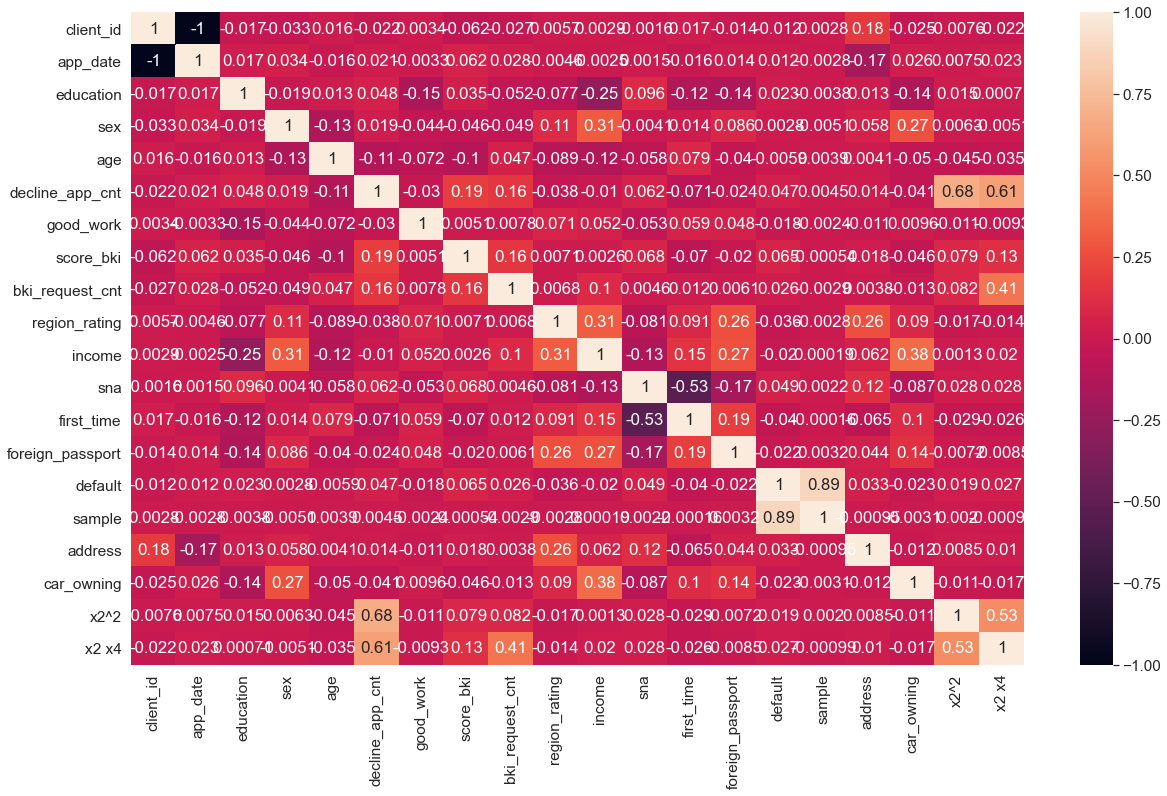

In [48]:
corr = data.corr()
f, ax = plt.subplots(figsize=(20,12))
sns.heatmap(corr, vmax=1, vmin=-1, annot=True)

## Модель 

выполним разделение заново 

In [49]:
train = data.query('sample == 1').drop(['sample'], axis=1)
test = data.query('sample == 0').drop(['sample'], axis=1)

In [50]:
# Проверим на соответствие значений:
print('Размер тренировочного датасета: ', train.shape,
      'Размер тестового датасета: ', test.shape, sep='\n')

Размер тренировочного датасета: 
(73799, 19)
Размер тестового датасета: 
(36349, 19)


In [51]:
# Выводим категориальные переменные в 0 или 1.
X_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)

Сгладим распределения непрерывных признаков, уменьшив влияние сильно отстоящих значений.

In [52]:
num_cols

['app_date',
 'age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'income']

In [53]:
# Стандартизация числовых переменных:
X_num = StandardScaler().fit_transform(train[num_cols].values)

In [54]:
# Объединим стандартизованные числовые, полиномиальные, бинарные и закодированные категориальные переменные в одно 
# признаковое пространство, разделив при этом признаки и целевую переменную.
X = np.hstack([X_num, train[bin_cols].values, train[poly_cols].values, X_cat])
Y = train['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=random_seed)
# попробуем добавить семплинг: 
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = random_seed,  stratify=Y)

In [55]:
X_test.shape

(14760, 43)

In [56]:
model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=random_seed, max_iter = 1000, penalty='l2', C=1)

In [57]:
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

In [58]:
y_pred = model.predict(X_test)

In [59]:
y_pred.shape

(14760,)

In [60]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

In [61]:

probs.shape


(14760,)

<AxesSubplot:>

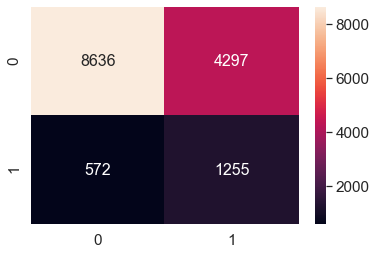

In [62]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4) 
sns.heatmap(conf_mat, annot=True, annot_kws={"size": 16}, fmt='g')

Очень хотелось бы снизить значение FP, дефолтных клиентов, которых классифицировали как заслуживающих доверия. Возможно, для этого необходимо больше данных для выявления закономерностей.

In [63]:
metrics = classification_report(y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn') 
print(metrics)


              precision    recall  f1-score   support

           0       0.94      0.67      0.78     12933
           1       0.23      0.69      0.34      1827

    accuracy                           0.67     14760
   macro avg       0.58      0.68      0.56     14760
weighted avg       0.85      0.67      0.73     14760



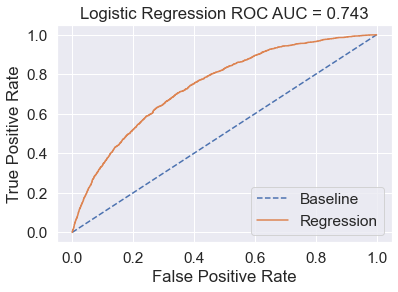

In [64]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

### Подбор гиперпараметров: 

поскольку в юпитере эта ячейка отработала нормально, оптимальные параметры все же высчитаны:

Лучшее Penalty: l2
Лучшее C: 1

## Submission

In [65]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values)
X_test_test = np.hstack([X_num_test, test[bin_cols].values, test[poly_cols].values, X_cat_test])
y_probs = model.predict_proba(X_test_test)[:,1]

Применяем полученный результат на тестовых данных

In [66]:
test['default'] = y_probs

In [67]:
submission = test[['client_id','default']]
print(submission.sample(10))
print(submission.shape)

        client_id   default
82988       55409  0.720093
84879       57151  0.520235
75674       25644  0.785753
91913       45827  0.709455
75335       45583  0.674262
85043       91840  0.774856
91067       18496  0.414307
108593      53497  0.575965
88689       89233  0.292109
109307      94040  0.087368
(36349, 2)


In [68]:
submission.to_csv('submission.csv', index=False)
submission

client_id   default
73799       74835  0.199506
73800       17527  0.816302
73801       75683  0.298104
73802       26883  0.406899
73803       28862  0.150923
...           ...       ...
110143      83775  0.749346
110144     106254  0.110972
110145      81852  0.782470
110146       1971  0.601111
110147      69044  0.691182

[36349 rows x 2 columns]

#Выводы 
